In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load your CSV file
csv_file_path = 'Final_data.csv'
df = pd.read_csv(csv_file_path)

In [3]:
df

,Unnamed: 0,ix,date,id,link,retweet,text,author,Hashtag count,Punctuation count,Character count,word_count,Mentions Count,Unnamed: 13,Acronym Count,URL Count,Unnamed: 16,combined_vector,clean_text
0,399,399,25-Sep,7.800000e+17,/amardeepkaushal/status/780133028010004481,1,"""@kdnuggets: #icymi #bigdata and the internet ...",various,3,16,136,16,0,NaN,1,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",kdnuggets icymi bigdata and the internet of th...
1,5168,5168,11-Jun,7.420000e+17,/EdgarSanchez/status/741764638975500290,1,"""@kdnuggets: r or #python? consider learning b...",various,3,15,139,22,0,NaN,1,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",kdnuggets r or python consider learning both k...
2,5836,5836,28-May,7.370000e+17,/MaxNigrelli72/status/736596414864752641,1,"""@kdnuggets: #deeplearning in a nutshell what...",various,2,17,139,22,0,NaN,1,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",kdnuggets deeplearning in a nutshell what it ...
3,6780,6780,09-May,7.300000e+17,/MaxNigrelli72/status/729768855522906113,1,"""@kdnuggets: how #bigdata helps build smart ci...",various,2,19,124,16,0,NaN,1,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",kdnuggets how bigdata helps build smart cities...
4,8993,8993,01-Apr,7.160000e+17,/PrecisionPoint2/status/716037533671534592,1,"""@kdnuggets #machinelearning as a service: how...",various,2,16,130,14,0,NaN,0,2,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",kdnuggets machinelearning as a service how dat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,995,995,21-Mar,7.120000e+17,/NASA/status/712078845013336069,0,weather forecast is 90% go for 11:05pm et tues...,NASA,1,14,150,16,1,NaN,2,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",weather forecast is 90 go for 1105pm et tuesda...
1996,996,996,21-Mar,7.120000e+17,/NASA/status/712062234214723584,0,new map of mars’ gravity provides revealing gl...,NASA,0,10,145,17,0,NaN,0,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",new map of mars’ gravity provides revealing gl...
1997,997,997,21-Mar,7.120000e+17,/NASA/status/712056194861555712,0,where will future astronauts live? nextstep as...,NASA,0,11,146,16,0,NaN,0,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",where will future astronauts live nextstep ask...
1998,998,998,21-Mar,7.120000e+17,/NASA/status/712026755020791811,0,"for the 1st time, brilliant flash of an explod...",NASA,0,12,145,16,1,NaN,0,1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",for the 1st time brilliant flash of an explodi...


In [4]:
# Load GloVe word vectors
glove_file_path = 'glove.6B.100d.txt'  # Change the path based on your downloaded file
word_embeddings = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

In [5]:
# Function to get the vector representation of a sentence
def get_sentence_vector(sentence):
    if pd.isna(sentence):  # Check for NaN values
        return np.zeros(100)
    
    vectors = [word_embeddings.get(word, np.zeros(100)) for word in sentence.split()]
    vectors = [vec for vec in vectors if vec.shape == (100,)]  # Filter out zero vectors
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Return zero vector if no valid vectors are found

In [6]:
# Combine text and numeric features
df['text_vector'] = df['text'].apply(get_sentence_vector)
X_text = np.vstack(df['text_vector'].to_numpy())
X_numeric = df[['Hashtag count', 'Punctuation count', 'Character count', 'word_count', 'Mentions Count', 'Acronym Count', 'URL Count']].values
X_combined = np.hstack((X_text, X_numeric))

In [7]:
X = X_combined
y = df['retweet']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [8]:
# Tokenize and pad the text sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X_text_tokenized = tokenizer.texts_to_sequences(df['text'])
X_text_padded = pad_sequences(X_text_tokenized)

In [9]:
# Build the RNN model using the functional API
text_input = Input(shape=(X_text_padded.shape[1],))
numeric_input = Input(shape=(X_numeric.shape[1],))

In [10]:
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_text_padded.shape[1])(text_input)
lstm_layer = LSTM(100)(embedding_layer)
combined_layer = Concatenate()([lstm_layer, numeric_input])
output_layer = Dense(1, activation='sigmoid')(combined_layer)

In [11]:
model = Model(inputs=[text_input, numeric_input], outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
model.fit([X_text_padded, X_numeric], y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
50/50 [==============================] - 10s 112ms/step - loss: 1.2845 - accuracy: 0.5206 - val_loss: 0.8660 - val_accuracy: 0.4725
Epoch 2/10
50/50 [==============================] - 4s 87ms/step - loss: 0.3565 - accuracy: 0.8344 - val_loss: 0.0599 - val_accuracy: 0.9850
Epoch 3/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0337 - accuracy: 0.9975 - val_loss: 0.0248 - val_accuracy: 0.9950
Epoch 4/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0134 - accuracy: 0.9987 - val_loss: 0.0279 - val_accuracy: 0.9950
Epoch 5/10
50/50 [==============================] - 4s 87ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9950
Epoch 6/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0441 - val_accuracy: 0.9875
Epoch 7/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0285 - val_accuracy: 0.9900
Epoch 8/10


In [13]:
# Evaluate the model
y_pred_proba = model.predict([X_text_padded, X_numeric])
y_pred = (y_pred_proba > 0.5).astype(int)

63/63 [==============================] - 2s 21ms/step


In [14]:
accuracy = accuracy_score(y, y_pred)


In [15]:
print(f'LSTM Accuracy: {accuracy:.2f}\n ')
report = classification_report(y, y_pred, target_names=['1', '0'])
print(report)

LSTM Accuracy: 1.00
 
              precision    recall  f1-score   support

           1       1.00      0.99      1.00      1000
           0       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [16]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

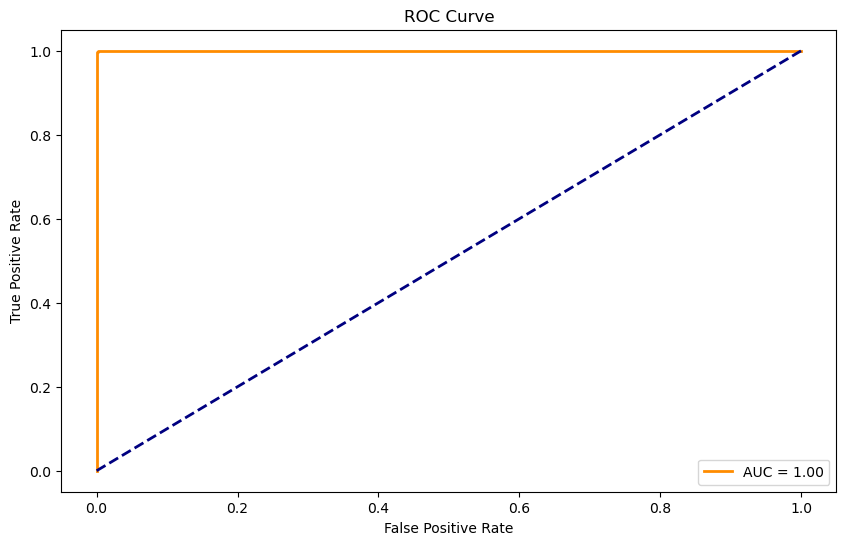

In [17]:
# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
